In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from celltype_ibl.models.BiModalEmbedding import BimodalEmbeddingModel
import torch
import numpy as np
from joblib import load
from celltype_ibl.utils.ibl_data_util import get_ibl_wvf_acg_pairs

latent_dim=512
encode_model = BimodalEmbeddingModel(
            layer_norm=False,
            latent_dim=latent_dim,
            l2_norm=True,
            activation="gelu",
        )
model_path = "ibl_CLIP_picked_wo_amp_jitter/seed_42_checkpoint.pt"
# Pick GPU if one is available, otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(model_path, map_location=torch.device)
encode_model.load_state_dict(checkpoint["model_state_dict"])
encode_model.eval()

wvf, acg, cosmos_region, fold_idx = get_ibl_wvf_acg_pairs(return_region="cosmos")

test_fold = [3, 6]
test_idx = [
    index
    for index, element in enumerate(fold_idx)
    if (element in test_fold)
    and (cosmos_region[index] != "void")
    and (cosmos_region[index] != "root")
]

test_wvf = wvf[test_idx].reshape(-1, 90)
test_acg = acg[test_idx].reshape(-1, 10, 101)

test_wvf = torch.tensor(test_wvf.astype("float32"))
test_acg = torch.tensor(test_acg.astype("float32"))


test_wvf_rep, test_acg_rep = encode_model.representation(
                test_wvf,
                test_acg.reshape(-1, 1, 10, 101) * 10,
            )

test_wvf_rep = test_wvf_rep.detach().cpu().numpy()
test_acg_rep = test_acg_rep.detach().cpu().numpy()

#load linear model
filename = f"contrastive_seed_42_linear/contrastive_linear_label_ratio_1_0.joblib"

# Load the model
clf = load(filename)
test_input_data = np.concatenate([test_wvf_rep, test_acg_rep], axis=1)
all_proba_predictions = clf.predict_proba(test_input_data)
all_predictions = np.argmax(all_proba_predictions, axis=1)

/mnt/home/hyu10/ceph/miniforge3/envs/celltype_ibl/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/mnt/home/hyu10/ceph/miniforge3/envs/celltype_ibl/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.4.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/mnt/home/hyu10/ceph/miniforge3/envs/celltype_ibl/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Tryi

In [35]:
unique_labels,_ = np.unique(cosmos_region, return_inverse=True)
labelling = {l: i for i, l in enumerate(unique_labels)}
correspondence = {i: l for i, l in enumerate(unique_labels)}
predicted_label = [correspondence[l] for l in all_predictions]

In [36]:
true_label = cosmos_region[test_idx]

In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_label,predicted_label, normalize='true')

/tmp/ipykernel_608667/1305361087.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0, rect=[0, 0, 0.85, 1])  # Adjust layout to fit colorbar


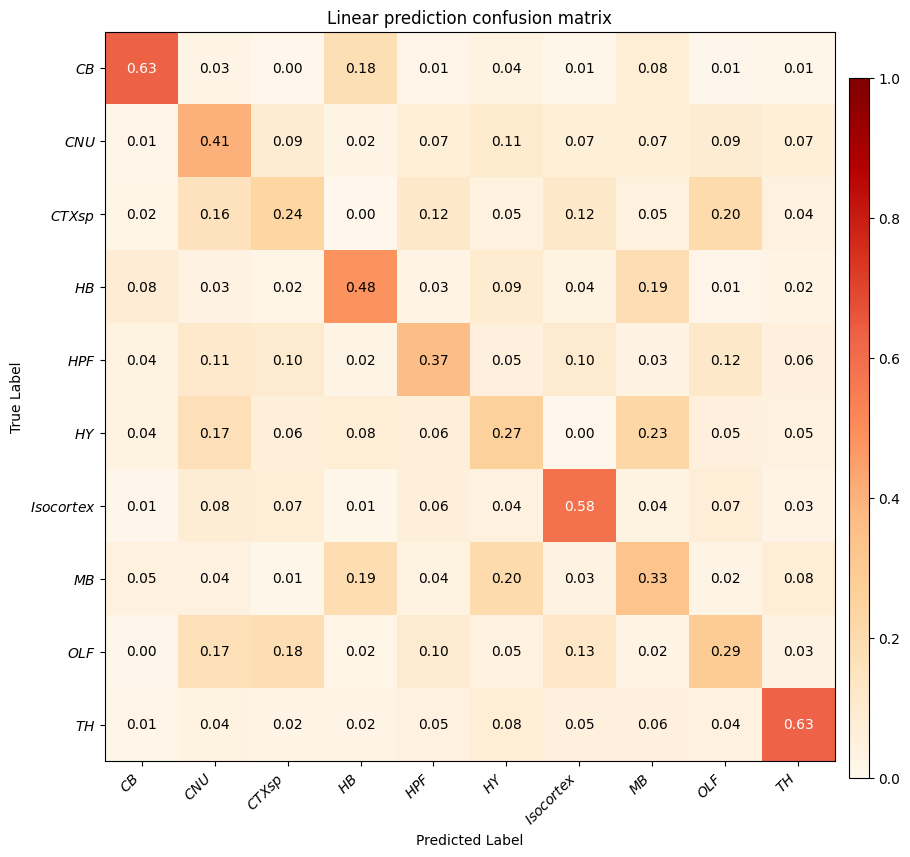

In [47]:
import matplotlib.pyplot as plt

cmap = "OrRd"  # Define colormap to use in all subplots and colorbar
norm = plt.Normalize(vmin=0, vmax=1)  # Normalization for the colorbar

fig, ax= plt.subplots(1, 1, figsize=[10, 10])
        
# Set subtitles for rows using figure text

im = ax.imshow(cm, cmap=cmap, norm=norm, aspect="equal",interpolation = None)
for k in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = ax.text(j, k, format(cm[k, j], ".2f"),
                              ha="center", va="center", color='black' if cm[k, j] < (1/2) else 'white')
ax.set_title("Linear prediction confusion matrix")
ax.set_xticks(np.arange(len(unique_labels)), labels=[f'${l}$' for l in unique_labels], rotation=45, ha='right')
ax.set_yticks(np.arange(len(unique_labels)), labels=[f'${l}$' for l in unique_labels])


ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

# # Add colorbar to the figure
fig.subplots_adjust(right=0.9)  # Make room for the colorbar
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])  # Position of colorbar
fig.colorbar(im, cax=cbar_ax)

plt.tight_layout(pad=1.0, rect=[0, 0, 0.85, 1])  # Adjust layout to fit colorbar